<a href="https://colab.research.google.com/github/nat-dsi/capstone/blob/main/Bitcoin_Elliptic_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Anomaly Detection in Bitcoin Transactions </h1>

<p float="left">
  <img src="https://www.moneytaskforce.com/wp-content/uploads/2019/07/95995559_s.jpg" width="500" height="400" />
  <img src="https://upload.wikimedia.org/wikipedia/commons/4/4f/%EA%B0%90%EC%97%BC%EC%82%AC%EC%A7%84.png" width="500" height="400"/> 
</p>

<H3> Objective </H3>

Objective of this project is to detect anomalies in Bitcoin transactions. Question that we're trying to answer is - Given a set of transactions, can we predict transactions that are not confirming to standard transaction pattern in Bitcoin network? 

Before that, some background, Bitcoin is the largest cryto-currency network. Its an de-centralized network for money exchange and there is no central authority to monitor the whole network for any illegal activities. There is no indetification or KYC type of process in place to control who can enter and trasact on Bitcoin network. This is a biggest advantage of the Bitcoin network but at the same time, the same structure allows illegal entities to operate on this network freely. 

There are many illegal activities that for which Bitcoin network is being used - like Anti-Money Laudering, Ransomware Heist etc.,

There are various techniques published by research papers to address this problem. This project uses techniques published by one of such [research paper](https://arxiv.org/abs/1908.02591) to detect anomalies and there by classify illicit activites from licit ones.

In [ ]:
from google.colab import files
files.upload()

In [2]:
! pip install -q kaggleA
! pip install -q kaggle-cli
! mkdir -p ~/.kaggle
! mv kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ellipticco/elliptic-data-set -p elliptic

ERROR: Could not find a version that satisfies the requirement kaggleA (from versions: none)
ERROR: No matching distribution found for kaggleA
     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 4.2MB 6.0MB/s 
     |████████████████████████████████| 112kB 43.5MB/s 
     |████████████████████████████████| 143kB 43.4MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-rsm4pkkj/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-rsm4pkkj/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-8qqkovfb/install-record.txt --single-version-externally-managed --compi

In [3]:
! ls

elliptic  sample_data


In [4]:
! ls elliptic/

elliptic-data-set.zip


In [5]:
! unzip elliptic/elliptic-data-set.zip

Archive:  elliptic/elliptic-data-set.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  


In [6]:
! ls elliptic_bitcoin_dataset/

elliptic_txs_classes.csv  elliptic_txs_edgelist.csv  elliptic_txs_features.csv


In [7]:
#importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import classification_report


<H2> Dataset and Data dictionary <H2>



We will be using [Elliptic Dataset](https://medium.com/elliptic/the-elliptic-data-set-opening-up-machine-learning-on-the-blockchain-e0a343d99a14) for this project. Its available on [Kaggle](https://www.kaggle.com/ellipticco/elliptic-data-set). This dataset is released to public by Elliptic so researchers can use real-world data for use cases like AML, Ransomware Heist and other illegal activities.

This dataset has 200K transactions that are partially labeled as 'licit' or 'illicit'. Around 4K transactions are marked 'illicit' and about 42K as 'illicit'. Rest of them are not labeled and it could be used for semi-supervised learning.

The key thing about this dataset compared to few other bitcoin datasets is that, this dataset has graph information of each of these transactions and so it can be used to determine 'illicit' transaction vs 'licit' ones. 

Apart from graph information, this dataset also has 166 features for each node (each transaction is represented as a node). It has a column to specify the timestep that each node/transacion belong to. There are 49 timesteps and a timestep is a period of about 2 weeks. 

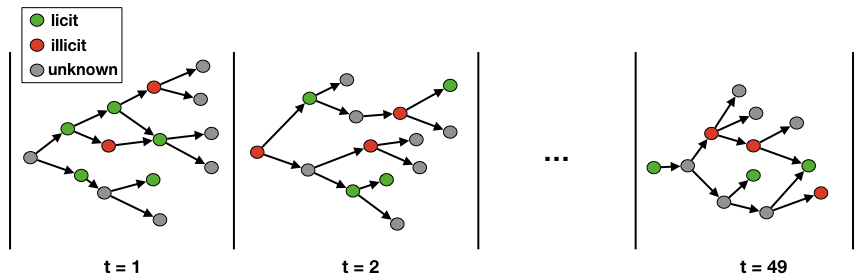

Out of 166 features, first 94 of them contains *local* information about the node itself like number of inputs/outputs, transaction fee, output volume and aggregated features like average BTC received (or spent) by inputs/outputs and average number of incoming (or outgoing) transactions with inputs/outputs.

The remaining 72 features are for *nonlocal (graph)* information about neighboring nodes (limited to one-hop forward/backward from the center node) and this information is at max, min, std deviation and correlation coeffients of the neighbor transactions w.r.t the local data - ave BTC, number of incoming/outgoing, transacton fee etc.,

In [8]:
# Give column names based on data description
id_time=["txId", "time_step"]
local_feature_names = ['local_feature_' + str(i) for i in range(1, 94)]
aggregate_feature_names = ['agg_feature_'+ str(i) for i in range(94, 166)]
column_names = id_time + local_feature_names + aggregate_feature_names

In [9]:
classes_df = pd.read_csv('./elliptic_bitcoin_dataset/elliptic_txs_classes.csv')

In [10]:
classes_df.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [11]:
classes_df['class'].value_counts()

unknown    157205
2           42019
1            4545
Name: class, dtype: int64

In [12]:
classes_df.shape

(203769, 2)

In [13]:
features_df = pd.read_csv('./elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None, names=column_names)
features_df.head()

,txId,time_step,local_feature_1,local_feature_2,local_feature_3,local_feature_4,local_feature_5,local_feature_6,local_feature_7,local_feature_8,local_feature_9,local_feature_10,local_feature_11,local_feature_12,local_feature_13,local_feature_14,local_feature_15,local_feature_16,local_feature_17,local_feature_18,local_feature_19,local_feature_20,local_feature_21,local_feature_22,local_feature_23,local_feature_24,local_feature_25,local_feature_26,local_feature_27,local_feature_28,local_feature_29,local_feature_30,local_feature_31,local_feature_32,local_feature_33,local_feature_34,local_feature_35,local_feature_36,local_feature_37,local_feature_38,...,agg_feature_126,agg_feature_127,agg_feature_128,agg_feature_129,agg_feature_130,agg_feature_131,agg_feature_132,agg_feature_133,agg_feature_134,agg_feature_135,agg_feature_136,agg_feature_137,agg_feature_138,agg_feature_139,agg_feature_140,agg_feature_141,agg_feature_142,agg_feature_143,agg_feature_144,agg_feature_145,agg_feature_146,agg_feature_147,agg_feature_148,agg_feature_149,agg_feature_150,agg_feature_151,agg_feature_152,agg_feature_153,agg_feature_154,agg_feature_155,agg_feature_156,agg_feature_157,agg_feature_158,agg_feature_159,agg_feature_160,agg_feature_161,agg_feature_162,agg_feature_163,agg_feature_164,agg_feature_165
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,-0.049707,-0.164402,-0.028741,-0.035391,-0.042955,-0.013282,-0.057195,-0.169609,-0.171154,-0.174473,-1.373657,-1.371460,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.120950,-0.199145,-0.187993,-0.212948,1.064205,1.063787,-1.373782,-1.354735,-0.297975,-1.403698,1.342003,1.340733,-0.171601,-0.458162,-0.423588,-0.440883,-1.015963,-1.016230,-0.968903,-0.375715,0.759748,-0.768329,1.488113,1.487932,-0.216814,-0.605631,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.

In [14]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 167 entries, txId to agg_feature_165
dtypes: float64(165), int64(2)
memory usage: 259.6 MB


In [15]:
features_by_timestep = features_df.groupby(by='time_step')['txId'].count()

In [16]:
features_by_timestep.head()

time_step
1    7880
2    4544
3    6621
4    5693
5    6803
Name: txId, dtype: int64

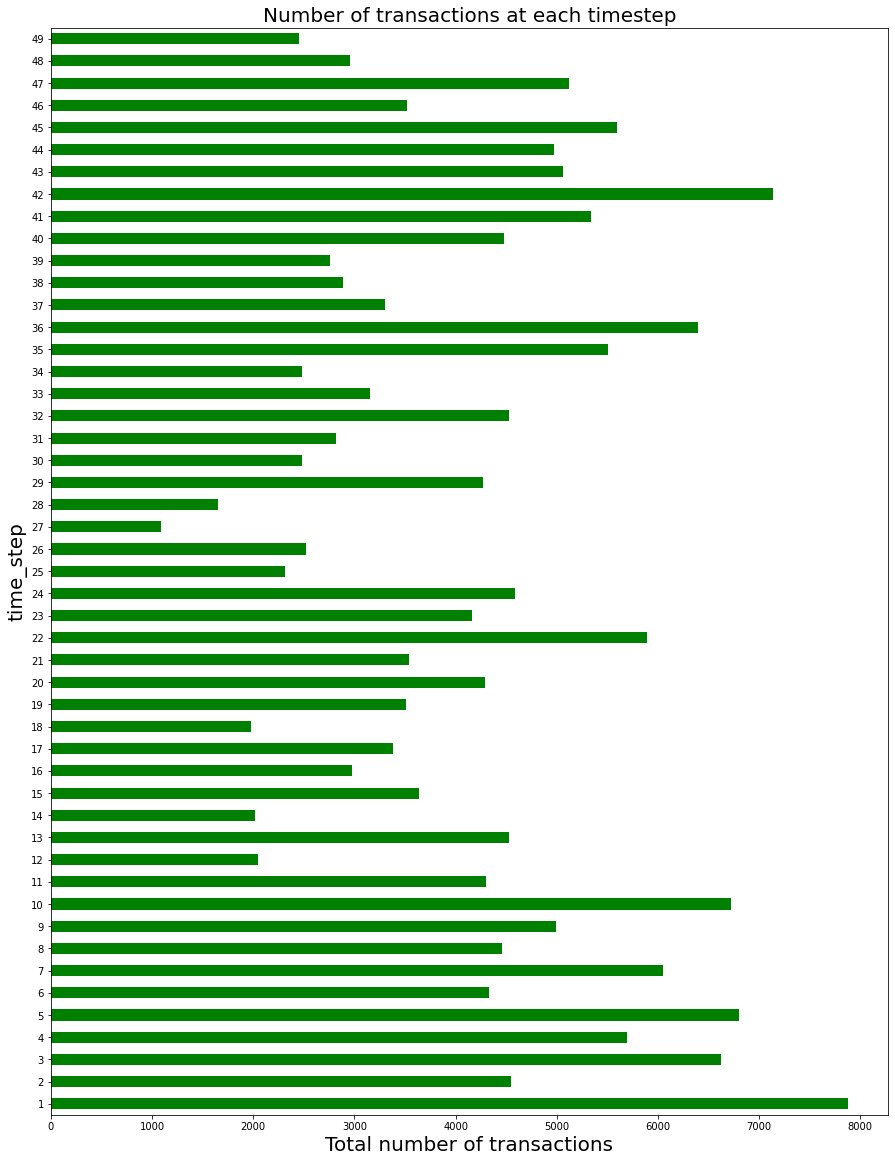

In [17]:
plt.figure(figsize=(15,20))
plt.xlabel('Total number of transactions', fontsize=20)
plt.ylabel('Time Step', fontsize=20)
plt.title('Number of transactions at each timestep', fontsize=20)
features_by_timestep.plot(kind='barh', color='green');

In [18]:
edges_df = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
edges_df.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [19]:
merged_df = pd.merge(classes_df, features_df, on='txId')
merged_df.head()

,txId,class,time_step,local_feature_1,local_feature_2,local_feature_3,local_feature_4,local_feature_5,local_feature_6,local_feature_7,local_feature_8,local_feature_9,local_feature_10,local_feature_11,local_feature_12,local_feature_13,local_feature_14,local_feature_15,local_feature_16,local_feature_17,local_feature_18,local_feature_19,local_feature_20,local_feature_21,local_feature_22,local_feature_23,local_feature_24,local_feature_25,local_feature_26,local_feature_27,local_feature_28,local_feature_29,local_feature_30,local_feature_31,local_feature_32,local_feature_33,local_feature_34,local_feature_35,local_feature_36,local_feature_37,...,agg_feature_126,agg_feature_127,agg_feature_128,agg_feature_129,agg_feature_130,agg_feature_131,agg_feature_132,agg_feature_133,agg_feature_134,agg_feature_135,agg_feature_136,agg_feature_137,agg_feature_138,agg_feature_139,agg_feature_140,agg_feature_141,agg_feature_142,agg_feature_143,agg_feature_144,agg_feature_145,agg_feature_146,agg_feature_147,agg_feature_148,agg_feature_149,agg_feature_150,agg_feature_151,agg_feature_152,agg_feature_153,agg_feature_154,agg_feature_155,agg_feature_156,agg_feature_157,agg_feature_158,agg_feature_159,agg_feature_160,agg_feature_161,agg_feature_162,agg_feature_163,agg_feature_164,agg_feature_165
0,230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,-0.049707,-0.164402,-0.028741,-0.035391,-0.042955,-0.013282,-0.057195,-0.169609,-0.171154,-0.174473,-1.373657,-1.371460,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,...,-0.097719,-0.127462,0.003143,0.002426,-0.120950,-0.199145,-0.187993,-0.212948,1.064205,1.063787,-1.373782,-1.354735,-0.297975,-1.403698,1.342003,1.340733,-0.171601,-0.458162,-0.423588,-0.440883,-1.015963,-1.016230,-0.968903,-0.375715,0.759748,-0.768329,1.488113,1.487932,-0.216814,-0.605631,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,unknown,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.02

In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203769 entries, 0 to 203768
Columns: 168 entries, txId to agg_feature_165
dtypes: float64(165), int64(2), object(1)
memory usage: 262.7+ MB


In [21]:
merged_df = merged_df[merged_df['class'].isin(['1','2'])]

In [22]:
merged_df['class'].value_counts()

2    42019
1     4545
Name: class, dtype: int64

<H3> Feature Selection and Scaling </H3>

There are 166 features in this dataset including timestep. We're going to remove timestep and then create two X variables - X and X_LF. X will have ALL the features both local and aggregate features from neighboring nodes. X_LF will contain features ONLY from local node. This is to differentiate and measure how graph/relational information from neighboring nodes influence the model. 

X - local + aggregate feartures - 165 features
X_LF - only local - first 93 features

In [23]:
X = merged_df[local_feature_names+aggregate_feature_names]
X_LF = merged_df[local_feature_names]
y = merged_df[['class']]
y = y['class'].apply(lambda x: 0 if x == '2' else 1)

In [24]:
X.shape

(46564, 165)

In [25]:
len(y)

46564

In [26]:
y.sum()

4545

In [27]:
X.head()

,local_feature_1,local_feature_2,local_feature_3,local_feature_4,local_feature_5,local_feature_6,local_feature_7,local_feature_8,local_feature_9,local_feature_10,local_feature_11,local_feature_12,local_feature_13,local_feature_14,local_feature_15,local_feature_16,local_feature_17,local_feature_18,local_feature_19,local_feature_20,local_feature_21,local_feature_22,local_feature_23,local_feature_24,local_feature_25,local_feature_26,local_feature_27,local_feature_28,local_feature_29,local_feature_30,local_feature_31,local_feature_32,local_feature_33,local_feature_34,local_feature_35,local_feature_36,local_feature_37,local_feature_38,local_feature_39,local_feature_40,...,agg_feature_126,agg_feature_127,agg_feature_128,agg_feature_129,agg_feature_130,agg_feature_131,agg_feature_132,agg_feature_133,agg_feature_134,agg_feature_135,agg_feature_136,agg_feature_137,agg_feature_138,agg_feature_139,agg_feature_140,agg_feature_141,agg_feature_142,agg_feature_143,agg_feature_144,agg_feature_145,agg_feature_146,agg_feature_147,agg_feature_148,agg_feature_149,agg_feature_150,agg_feature_151,agg_feature_152,agg_feature_153,agg_feature_154,agg_feature_155,agg_feature_156,agg_feature_157,agg_feature_158,agg_feature_159,agg_feature_160,agg_feature_161,agg_feature_162,agg_feature_163,agg_feature_164,agg_feature_165
3,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,0.026315,-0.227215,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
9,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,0.020069,-0.163135,1.696691,2.414968,-0.063200,-0.013282,2.370512,0.001525,-0.172908,0.221419,-0.243300,-0.243452,-0.139732,-0.147416,-0.079747,-0.155559,0.665165,1.037078,-0.139734,-0.147411,-0.079746,-0.155559,0.665251,1.037113,-0.024669,-0.031272,-0.023045,-0.026215,-0.973502,-0.973372,-0.227159,...,-0.086194,-0.124629,0.525309,0.617474,0.317264,-0.121020,-0.188716,-0.032710,-0.047722,-0.048171,-1.373902,-1.356289,-0.301754,-1.404621,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
10,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,-0.049707,-0.140266,-0.028741,-0.035391,-0.042955,-0.013282,-0.006754,-0.148916,-0.151494,-0.146513,0.887058,0.884557,-0.139721,-0.148905,-0.080147,-0.155653,-0.010763,-0.012107,-0.139723,-0.148901,-0.080147,-0.155653,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.097719,-0.127462,0.003143,0.002426,-0.115680,-0.190199,-0.177836,-0.201578,1.064205,1.063787,-1.373932,-1.356183,-0.301411,-1.404577,-0.975738,-0.975237,-0.168742,-0.445357,-0.409015,-0.427594,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
11,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,-0.049707,-0.143847,-0.028741,-0.035391,-0.042955,-0.013282,-0.038424,-0.150266,-0.150457,-0.150661,0.887058,0.884557,-0.139722,-0.148906,-0.080147,-0.155654,-0.010763,-0.012107,-0.139724,-0.148902,-0.080147,-0.155654,-0.010669,-0.012005,-0.024

In [28]:
X_LF.head()

,local_feature_1,local_feature_2,local_feature_3,local_feature_4,local_feature_5,local_feature_6,local_feature_7,local_feature_8,local_feature_9,local_feature_10,local_feature_11,local_feature_12,local_feature_13,local_feature_14,local_feature_15,local_feature_16,local_feature_17,local_feature_18,local_feature_19,local_feature_20,local_feature_21,local_feature_22,local_feature_23,local_feature_24,local_feature_25,local_feature_26,local_feature_27,local_feature_28,local_feature_29,local_feature_30,local_feature_31,local_feature_32,local_feature_33,local_feature_34,local_feature_35,local_feature_36,local_feature_37,local_feature_38,local_feature_39,local_feature_40,...,local_feature_54,local_feature_55,local_feature_56,local_feature_57,local_feature_58,local_feature_59,local_feature_60,local_feature_61,local_feature_62,local_feature_63,local_feature_64,local_feature_65,local_feature_66,local_feature_67,local_feature_68,local_feature_69,local_feature_70,local_feature_71,local_feature_72,local_feature_73,local_feature_74,local_feature_75,local_feature_76,local_feature_77,local_feature_78,local_feature_79,local_feature_80,local_feature_81,local_feature_82,local_feature_83,local_feature_84,local_feature_85,local_feature_86,local_feature_87,local_feature_88,local_feature_89,local_feature_90,local_feature_91,local_feature_92,local_feature_93
3,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,0.026315,-0.227215,...,4.346640,1.777963,-1.451545,-1.530250,4.628683,0.513804,-0.163126,1.208220,-0.196435,-0.196189,4.629650,0.513869,-0.163115,1.208278,-0.196409,-0.196133,-0.017032,-0.030026,-0.01764,-0.015071,-0.140763,-0.140335,4.313295,0.216750,-0.250574,0.707151,-0.169119,-0.167165,6.220011,0.216948,-0.255168,0.717108,-0.187191,-0.185274,3.991587,0.810879,-0.694235,2.084651,0.025308,0.025217
9,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,0.020069,-0.163135,1.696691,2.414968,-0.063200,-0.013282,2.370512,0.001525,-0.172908,0.221419,-0.243300,-0.243452,-0.139732,-0.147416,-0.079747,-0.155559,0.665165,1.037078,-0.139734,-0.147411,-0.079746,-0.155559,0.665251,1.037113,-0.024669,-0.031272,-0.023045,-0.026215,-0.973502,-0.973372,-0.227159,...,3.633753,1.349956,-1.155577,-1.024980,4.628683,0.513804,-0.163126,1.208220,-0.196435,-0.196189,4.629650,0.513869,-0.163115,1.208278,-0.196409,-0.196133,-0.017032,-0.030026,-0.01764,-0.015071,-0.140763,-0.140335,4.313295,0.216750,-0.250574,0.707151,-0.169119,-0.167165,6.220011,0.216948,-0.255168,0.717108,-0.187191,-0.185274,3.991587,0.810879,-0.694235,2.084651,0.025308,0.025217
10,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,-0.049707,-0.140266,-0.028741,-0.035391,-0.042955,-0.013282,-0.006754,-0.148916,-0.151494,-0.146513,0.887058,0.884557,-0.139721,-0.148905,-0.080147,-0.155653,-0.010763,-0.012107,-0.139723,-0.148901,-0.080147,-0.155653,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.232553,-0.467503,0.048767,0.052956,-0.039114,-0.172877,-0.163113,-0.160909,-1.316342,-1.315388,-0.039109,-0.172866,-0.163101,-0.160903,-1.316333,-1.315375,-0.017032,-0.030026,-0.01764,-0.015071,-0.140763,-0.140335,-0.095403,-0.264408,-0.250557,-0.263736,-1.471764,-1.470277,-0.059013,-0.262405,-0.255149,-0.259232,-1.499972,-1.498585,-0.293841,-0.711861,-0.633648,-0.676279,-1.084907,-1.084845
11,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,-0.049707,-0.143847,-0.028741,-0.035391,-0.042955,-0.013282,-0.038424,-0.150266,-0.150457,-0.150661,0.887058,0.884557,-0.139722,-0.148906,-0.080147,-0.155654,-0.010763,-0.012107,-0.139724,-0.148902,-0.080147,

In [29]:
X_LF.shape

(46564, 93)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=33)
X_LF_train, X_LF_test, y_train, y_test = train_test_split(X_LF, y, test_size=0.30, random_state=33)

In [31]:
train_size = int(len(X) * 0.70)
X_train,X_test = X[0:train_size], X[train_size:len(X)]
X_LF_train,X_LF_test = X_LF[0:train_size], X_LF[train_size:len(X_LF)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [32]:
len(y_train)

32594

In [33]:
len(y_test)

13970

In [34]:
print(y_train.sum())
print(y_test.sum())

3666
879


In [35]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
X_LF_train_sc = sc.fit_transform(X_LF_train)
X_LF_test_sc = sc.transform(X_LF_test)

<H3> Logistic Regression with Local Features - Base Model </H3>

In [36]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_LF_train_sc, y_train.values)
y_preds = logreg.predict(X_LF_test_sc)

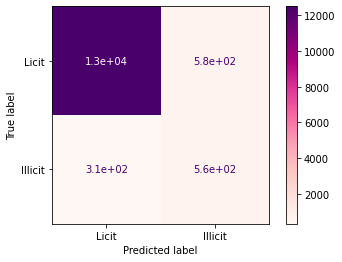

In [37]:
cm = confusion_matrix(y_test.values, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Licit', 'Illicit'])
disp.plot(cmap='RdPu');

In [38]:
print(classification_report(y_test.values, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     13091
           1       0.49      0.64      0.56       879

    accuracy                           0.94     13970
   macro avg       0.73      0.80      0.76     13970
weighted avg       0.95      0.94      0.94     13970



<H3> Logistic Regression - All Features <H3>

In [39]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_sc, y_train.values)
y_preds = logreg.predict(X_test_sc)

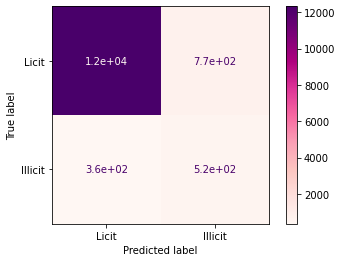

In [40]:
cm = confusion_matrix(y_test.values, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Licit', 'Illicit'])
disp.plot(cmap='RdPu');

In [41]:
print(classification_report(y_test.values, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     13091
           1       0.40      0.59      0.48       879

    accuracy                           0.92     13970
   macro avg       0.69      0.77      0.72     13970
weighted avg       0.94      0.92      0.93     13970



<H3> Randomforest Classifier with Local features <H3>

In [42]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rf.fit(X_LF_train_sc, y_train)
y_preds = rf.predict(X_LF_test_sc)

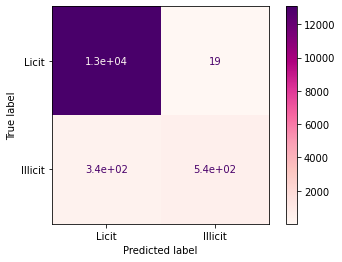

In [43]:
cm = confusion_matrix(y_test.values, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Licit', 'Illicit'])
disp.plot(cmap='RdPu');

In [44]:
print(classification_report(y_test.values, y_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     13091
           1       0.97      0.62      0.75       879

    accuracy                           0.97     13970
   macro avg       0.97      0.81      0.87     13970
weighted avg       0.97      0.97      0.97     13970



<H3> Randomforest Classifier - All Features <H3>

In [45]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rf.fit(X_train_sc, y_train)
y_preds = rf.predict(X_test_sc)

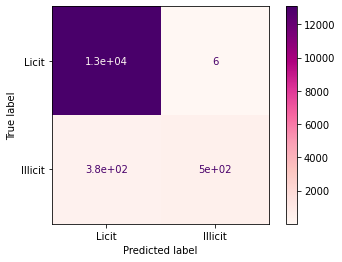

In [46]:
cm = confusion_matrix(y_test.values, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Licit', 'Illicit'])
disp.plot(cmap='RdPu');

In [47]:
print(classification_report(y_test.values, y_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     13091
           1       0.99      0.57      0.72       879

    accuracy                           0.97     13970
   macro avg       0.98      0.79      0.85     13970
weighted avg       0.97      0.97      0.97     13970



<H3> Feed Forward Neural Network <H3>

In [48]:
n_shape = X_train.shape[1]
model = Sequential()
model.add(Dense(128,
                input_shape=(n_shape,),
                activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-3)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(1e-3)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(1e-3)))
model.add(Dense(1, activation='sigmoid'))

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               21248     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [50]:
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'acc'])

In [51]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [52]:
history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=None,
    callbacks=[early_stop])

Epoch 1/200
1019/1019 [==============================] - 4s 3ms/step - loss: 0.1330 - mae: 0.1066 - acc: 0.9361 - val_loss: 0.0447 - val_mae: 0.0666 - val_acc: 0.9676
Epoch 2/200
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0314 - mae: 0.0446 - acc: 0.9776 - val_loss: 0.0395 - val_mae: 0.0548 - val_acc: 0.9679
Epoch 3/200
1019/1019 [==============================] - 3s 2ms/step - loss: 0.0272 - mae: 0.0421 - acc: 0.9787 - val_loss: 0.0354 - val_mae: 0.0520 - val_acc: 0.9703
Epoch 4/200
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0232 - mae: 0.0386 - acc: 0.9816 - val_loss: 0.0381 - val_mae: 0.0605 - val_acc: 0.9639
Epoch 5/200
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0225 - mae: 0.0372 - acc: 0.9819 - val_loss: 0.0334 - val_mae: 0.0481 - val_acc: 0.9694
Epoch 6/200
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0219 - mae: 0.0354 - acc: 0.9820 - val_loss: 0.0350 - val_mae: 0.0457 - val_acc: 0.967

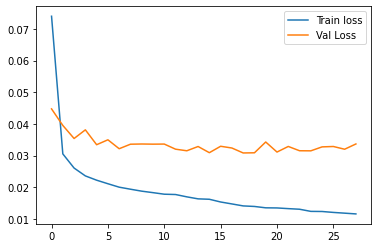

In [53]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

In [54]:
y_preds = model.predict(X_test)

In [55]:
y_preds = y_preds.round()

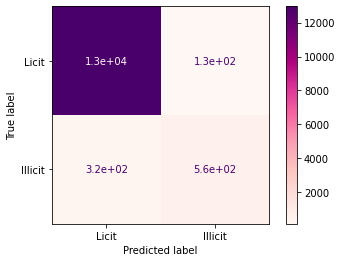

In [56]:
cm = confusion_matrix(y_test.values, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Licit', 'Illicit'])
disp.plot(cmap='RdPu');

In [57]:
print(classification_report(y_test.values, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     13091
           1       0.81      0.63      0.71       879

    accuracy                           0.97     13970
   macro avg       0.89      0.81      0.85     13970
weighted avg       0.97      0.97      0.97     13970

